In [1]:
import treescope
import torch
from pathlib import Path
from src.model import EvolutionOperator
import linear_operator_learning.nn as lol
treescope.basic_interactive_setup()

In [4]:
run_id = "zop41q22"
data_path = Path(f"/home/pnovelli/code/encoderops/encoderops_chignolin/{run_id}")
epoch = 499
model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
#embeddings = torch.load(data_path / f"embeddings/epoch={epoch}.pt")

In [5]:
import os
import pickle
data_path = Path(os.environ["CHIG_DATA_PATH"])
trajectory_files = [str(traj) for traj in data_path.glob("*.dcd")]
top = next(data_path.glob("*.pdb")).__str__()
name = next(data_path.glob("*.pdb")).stem
lagtime = model.data_args.lagtime
prepro_data_path = (
    Path().cwd() / f"preprocessed_data/{name}-lag{lagtime}.pkl"
)

# If the file exists then load it with pickle, otherwise call get_dataset and save it
if prepro_data_path.exists():
    with open(prepro_data_path, "rb") as f:
        dataset = pickle.load(f)

In [ ]:
from tqdm import tqdm
from torch_geometric.loader import DataLoader
embeddings = {"t": [], "lag": []}
model = model.eval()

for k, v in dataset.metadata.items():
    if torch.is_tensor(v):
        dataset.metadata[k] = v.to(model.device)

dataloader = DataLoader(
    dataset, batch_size=64, shuffle=False
)

for graph in tqdm(dataloader):
    # data
    graph = graph.to(model.device)
    x_t = model._setup_graph_data(graph, key="data_list")
    x_lag = model._setup_graph_data(graph, key="data_list_lag")
    # forward
    f_t = model.forward_nn(x_t)
    f_lag = model.forward_nn(x_lag, lagged=True)
    embeddings["t"].append((f_t.detach().cpu()))
    embeddings["lag"].append((f_lag.detach().cpu()))

  0%|          | 0/168 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper_CUDA_cat)

In [42]:
cov_X = lol.stats.covariance(embeddings["t"])
cov_Y = lol.stats.covariance(embeddings["lag"])
cov_XY = lol.stats.covariance(embeddings['lag'])
markov_model = lol.ridge_least_squares(cov_X, tikhonov_reg=1e-3)

In [43]:
markov_model

{'U': tensor([[ 2.4465e+00, -3.0105e+00, -2.6006e-01, -1.5304e+01, -5.8947e+00,
           1.0564e+01, -4.9841e+00,  1.3848e+01, -1.0043e+01,  1.0665e+01,
          -4.5459e+00,  5.8068e+00,  7.9806e-01, -3.0968e+00, -2.7725e+00,
           3.0910e-01],
         [ 2.4740e+00, -3.0297e+00, -2.5428e-01, -1.5328e+01,  1.9510e+01,
          -1.1904e+00, -8.3857e+00, -6.9232e+00,  9.4605e+00, -6.6237e-01,
           4.8540e-01,  1.3968e+00,  6.9697e-01,  7.0324e+00, -2.2758e+00,
           3.1762e-01],
         [ 2.4518e+00, -3.0193e+00, -2.6066e-01, -1.5331e+01, -9.3740e+00,
          -5.2329e+00,  1.3616e+01, -4.1169e+00,  7.9340e+00, -6.2167e+00,
          -6.6622e+00,  7.6040e+00,  3.2653e+00, -1.1516e+00, -1.0735e+00,
          -7.3074e-01],
         [ 2.4550e+00, -3.0190e+00, -2.5962e-01, -1.5327e+01, -4.2638e+00,
          -4.0738e+00, -2.5702e-01, -2.7877e+00, -7.3605e+00, -3.7815e+00,
           1.0722e+01, -1.4804e+01, -4.7603e+00, -2.7843e+00,  6.1218e+00,
           1.0402e-01],
         [-3.2710e+00,  2.1627e+00,  1.5270e+01, -1.2109e+00, -3.5825e+00,
          -3.7012e+00,  2.2605e+00,  6.8577e+00,  1.2074e+01,  2.8741e+00,
           1.8615e+01,  3.7196e+00,  3.9914e+00, -5.0063e+00, -1.9808e+00,
           2.8954e-01],
         [-3.2643e+00,  2.1566e+00,  1.5271e+01, -1.2256e+00,  1.2041e+00,
          -1.6554e+01,  2.2092e+00, -4.7467e+00, -7.0370e+00,  6.6642e+00,
          -1.3107e+01, -7.2505e+00, -9.3636e-01, -3.0969e+00, -2.9169e+00,
           3.0610e-01],
         [-3.2743e+00,  2.1669e+00,  1.5269e+01, -1.1970e+00, -1.7904e+00,
           1.2014e+01,  5.2521e+00,  1.7503e+00,  6.9417e+00,  3.3229e+00,
          -8.1232e+00,  1.9466e-01, -4.5902e+00,  9.8877e+00,  6.3966e+00,
           1.3531e-01],
         [-3.2683e+00,  2.1645e+00,  1.5270e+01, -1.1993e+00,  4.1700e+00,
           8.2414e+00, -9.7202e+00, -3.8629e+00, -1.1979e+01, -1.2862e+01,
           2.6157e+00,  3.3363e+00,  1.5353e+00, -1.7843e+00, -1.4990e+00,
          -7.3094e-01],
         [-6.4188e-01, -1.5365e+01,  2.2676e+00,  2.8925e+00,  1.9349e+00,
           8.2913e+00, -2.9010e+00, -5.0673e+00,  9.4410e+00, -3.1331e+00,
          -6.8289e+00, -1.1912e+00, -5.7505e+00, -1.5707e+01,  7.2099e-01,
           2.2580e-01],
         [-6.4468e-01, -1.5366e+01,  2.2658e+00,  2.8850e+00, -2.5237e+00,
           1.3321e+00,  8.1563e+00, -1.4822e+01, -1.0709e+01,  6.2213e+00,
           8.4671e+00,  1.0433e+01, -2.1049e+00,  5.3652e+00, -7.5730e-01,
           2.9465e-01],
         [-6.4282e-01, -1.5367e+01,  2.2671e+00,  2.8808e+00, -1.3490e+00,
          -1.0926e+01, -3.1434e+00,  1.5862e+01, -1.4914e+00, -1.4567e+01,
          -2.6501e+00,  3.5648e+00, -2.2033e+00,  6.5341e+00,  5.5157e-01,
           2.7455e-01],
         [-6.4224e-01, -1.5366e+01,  2.2676e+00,  2.8890e+00,  1.9133e+00,
           1.3116e+00, -2.1129e+00,  4.0306e+00,  2.7555e+00,  1.1479e+01,
           1.0119e+00, -1.2807e+01,  1.0059e+01,  3.8081e+00, -5.1526e-01,
          -7.9501e-01],
         [ 1.5250e+01,  3.0975e-01,  3.4063e+00,  2.3337e+00, -1.7371e+01,
           2.7268e+00, -1.1776e+01, -8.5091e+00,  5.2578e+00, -3.9440e+00,
          -1.6643e+00, -5.3655e+00,  2.9518e+00,  5.2638e+00, -2.9398e+00,
           3.1714e-01],
         [ 1.5265e+01,  2.9824e-01,  3.4102e+00,  2.3241e+00,  5.0035e+00,
          -6.7589e+00, -4.6672e+00, -4.3050e-01, -2.6657e+00,  3.9875e+00,
          -2.2358e+00,  1.0657e+01,  1.1283e+01, -4.8878e+00,  6.9589e+00,
           1.5097e-02],
         [ 1.5261e+01,  3.0075e-01,  3.4089e+00,  2.3341e+00,  9.2351e+00,
           8.4063e+00,  1.7916e+01,  4.6444e+00, -4.3215e+00, -7.3105e+00,
           5.3980e-01, -7.9084e+00,  4.0037e+00, -7.6015e-01, -2.7383e+00,
           2.9863e-01],
         [ 1.5263e+01,  2.9989e-01,  3.4098e+00,  2.3267e+00,  3.0886e+00,
          -4.3661e+00, -1.4649e+00,  4.3018e+00,  1.7241e+00,  7.2675e+00,
           3.3599e+00,  2.6167e+00, -1.8238e+01,  3.8397e-01, -1.2808e+00,
          -6.3087e-01]]),
 'V': ten

In [44]:
markov_model

{'U': tensor([[ 2.4465e+00, -3.0105e+00, -2.6006e-01, -1.5304e+01, -5.8947e+00,
           1.0564e+01, -4.9841e+00,  1.3848e+01, -1.0043e+01,  1.0665e+01,
          -4.5459e+00,  5.8068e+00,  7.9806e-01, -3.0968e+00, -2.7725e+00,
           3.0910e-01],
         [ 2.4740e+00, -3.0297e+00, -2.5428e-01, -1.5328e+01,  1.9510e+01,
          -1.1904e+00, -8.3857e+00, -6.9232e+00,  9.4605e+00, -6.6237e-01,
           4.8540e-01,  1.3968e+00,  6.9697e-01,  7.0324e+00, -2.2758e+00,
           3.1762e-01],
         [ 2.4518e+00, -3.0193e+00, -2.6066e-01, -1.5331e+01, -9.3740e+00,
          -5.2329e+00,  1.3616e+01, -4.1169e+00,  7.9340e+00, -6.2167e+00,
          -6.6622e+00,  7.6040e+00,  3.2653e+00, -1.1516e+00, -1.0735e+00,
          -7.3074e-01],
         [ 2.4550e+00, -3.0190e+00, -2.5962e-01, -1.5327e+01, -4.2638e+00,
          -4.0738e+00, -2.5702e-01, -2.7877e+00, -7.3605e+00, -3.7815e+00,
           1.0722e+01, -1.4804e+01, -4.7603e+00, -2.7843e+00,  6.1218e+00,
           1.0402e-01],
         [-3.2710e+00,  2.1627e+00,  1.5270e+01, -1.2109e+00, -3.5825e+00,
          -3.7012e+00,  2.2605e+00,  6.8577e+00,  1.2074e+01,  2.8741e+00,
           1.8615e+01,  3.7196e+00,  3.9914e+00, -5.0063e+00, -1.9808e+00,
           2.8954e-01],
         [-3.2643e+00,  2.1566e+00,  1.5271e+01, -1.2256e+00,  1.2041e+00,
          -1.6554e+01,  2.2092e+00, -4.7467e+00, -7.0370e+00,  6.6642e+00,
          -1.3107e+01, -7.2505e+00, -9.3636e-01, -3.0969e+00, -2.9169e+00,
           3.0610e-01],
         [-3.2743e+00,  2.1669e+00,  1.5269e+01, -1.1970e+00, -1.7904e+00,
           1.2014e+01,  5.2521e+00,  1.7503e+00,  6.9417e+00,  3.3229e+00,
          -8.1232e+00,  1.9466e-01, -4.5902e+00,  9.8877e+00,  6.3966e+00,
           1.3531e-01],
         [-3.2683e+00,  2.1645e+00,  1.5270e+01, -1.1993e+00,  4.1700e+00,
           8.2414e+00, -9.7202e+00, -3.8629e+00, -1.1979e+01, -1.2862e+01,
           2.6157e+00,  3.3363e+00,  1.5353e+00, -1.7843e+00, -1.4990e+00,
          -7.3094e-01],
         [-6.4188e-01, -1.5365e+01,  2.2676e+00,  2.8925e+00,  1.9349e+00,
           8.2913e+00, -2.9010e+00, -5.0673e+00,  9.4410e+00, -3.1331e+00,
          -6.8289e+00, -1.1912e+00, -5.7505e+00, -1.5707e+01,  7.2099e-01,
           2.2580e-01],
         [-6.4468e-01, -1.5366e+01,  2.2658e+00,  2.8850e+00, -2.5237e+00,
           1.3321e+00,  8.1563e+00, -1.4822e+01, -1.0709e+01,  6.2213e+00,
           8.4671e+00,  1.0433e+01, -2.1049e+00,  5.3652e+00, -7.5730e-01,
           2.9465e-01],
         [-6.4282e-01, -1.5367e+01,  2.2671e+00,  2.8808e+00, -1.3490e+00,
          -1.0926e+01, -3.1434e+00,  1.5862e+01, -1.4914e+00, -1.4567e+01,
          -2.6501e+00,  3.5648e+00, -2.2033e+00,  6.5341e+00,  5.5157e-01,
           2.7455e-01],
         [-6.4224e-01, -1.5366e+01,  2.2676e+00,  2.8890e+00,  1.9133e+00,
           1.3116e+00, -2.1129e+00,  4.0306e+00,  2.7555e+00,  1.1479e+01,
           1.0119e+00, -1.2807e+01,  1.0059e+01,  3.8081e+00, -5.1526e-01,
          -7.9501e-01],
         [ 1.5250e+01,  3.0975e-01,  3.4063e+00,  2.3337e+00, -1.7371e+01,
           2.7268e+00, -1.1776e+01, -8.5091e+00,  5.2578e+00, -3.9440e+00,
          -1.6643e+00, -5.3655e+00,  2.9518e+00,  5.2638e+00, -2.9398e+00,
           3.1714e-01],
         [ 1.5265e+01,  2.9824e-01,  3.4102e+00,  2.3241e+00,  5.0035e+00,
          -6.7589e+00, -4.6672e+00, -4.3050e-01, -2.6657e+00,  3.9875e+00,
          -2.2358e+00,  1.0657e+01,  1.1283e+01, -4.8878e+00,  6.9589e+00,
           1.5097e-02],
         [ 1.5261e+01,  3.0075e-01,  3.4089e+00,  2.3341e+00,  9.2351e+00,
           8.4063e+00,  1.7916e+01,  4.6444e+00, -4.3215e+00, -7.3105e+00,
           5.3980e-01, -7.9084e+00,  4.0037e+00, -7.6015e-01, -2.7383e+00,
           2.9863e-01],
         [ 1.5263e+01,  2.9989e-01,  3.4098e+00,  2.3267e+00,  3.0886e+00,
          -4.3661e+00, -1.4649e+00,  4.3018e+00,  1.7241e+00,  7.2675e+00,
           3.3599e+00,  2.6167e+00, -1.8238e+01,  3.8397e-01, -1.2808e+00,
          -6.3087e-01]]),
 'V': ten

In [65]:
G_0 = markov_model["U"]@markov_model["U"].T@cov_XY
G_1 = model.linear[0].weight.T.detach().cpu()@model.linear[1].weight.T.detach().cpu() @ cov_Y

In [66]:
G_0

tensor([[ 79.3390,  79.6224, -55.8430, -17.1611,   9.5360,  74.6024, -21.1616,
         -79.1475,  22.8430,  15.4536,  18.2250, -65.0838,  14.8200, -24.5702,
          28.9214, -42.3838],
        [ 88.4421,  88.7849, -62.2913, -19.1225,  10.5939,  83.1797, -23.5957,
         -88.2542,  25.4475,  17.2057,  20.2866, -72.5995,  16.5154, -27.3940,
          32.2403, -47.2422],
        [ 19.3244,  19.3761, -13.5345,  -4.1095,   2.3748,  18.1619,  -5.1168,
         -19.2535,   5.6162,   3.8220,   4.4846, -15.7911,   3.6432,  -5.9851,
           7.0370, -10.3134],
        [ -1.4901,  -1.4887,   1.0890,   0.4512,  -0.1374,  -1.3929,   0.4475,
           1.4781,  -0.3591,  -0.2187,  -0.3034,   1.2439,  -0.2288,   0.4481,
          -0.5532,   0.8029],
        [-52.9339, -53.1636,  37.3639,  11.5016,  -6.2834, -49.7979,  14.1602,
          52.8610, -15.1824, -10.2420, -12.0922,  43.5309,  -9.8530,  16.4021,
         -19.3019,  28.2910],
        [ 66.6846,  66.9388, -46.9492, -14.4128,   7.9951,  62.7157, -17.7828,
         -66.5308,  19.1893,  12.9765,  15.3029, -54.7226,  12.4589, -20.6484,
          24.3096, -35.6117],
        [-16.1320, -16.2004,  11.4146,   3.5171,  -1.9151, -15.1733,   4.3290,
          16.1303,  -4.6283,  -3.1203,  -3.6838,  13.2902,  -2.9951,   5.0092,
          -5.8832,   8.6462],
        [-32.6361, -32.7607,  23.0097,   7.0724,  -3.9067, -30.6910,   8.7216,
          32.5840,  -9.3883,  -6.3449,  -7.4822,  26.8096,  -6.0844,  10.1183,
         -11.8965,  17.4533],
        [  3.7049,   3.6974,  -2.5509,  -0.7286,   0.5057,   3.4703,  -0.9561,
          -3.6834,   1.1306,   0.7907,   0.9024,  -2.9853,   0.7232,  -1.1581,
           1.3417,  -1.9863],
        [-31.6741, -31.8149,  22.3835,   6.9362,  -3.7334, -29.8007,   8.4917,
          31.6299,  -9.0452,  -6.0871,  -7.2130,  26.0691,  -5.8786,   9.8025,
         -11.5581,  16.9271],
        [ -9.0781,  -9.1458,   6.4670,   1.9997,  -1.0248,  -8.5578,   2.4506,
           9.0947,  -2.5661,  -1.7127,  -2.0293,   7.5277,  -1.6697,   2.8163,
          -3.3128,   4.8505],
        [ 18.4566,  18.4982, -12.9325,  -3.9456,   2.2731,  17.3392,  -4.8968,
         -18.3902,   5.3625,   3.6492,   4.2859, -15.0817,   3.4716,  -5.7190,
           6.7220,  -9.8627],
        [-56.8941, -57.1081,  40.1279,  12.3765,  -6.7980, -53.4990,  15.2226,
          56.7996, -16.3437, -11.0379, -13.0315,  46.7441, -10.5887,  17.6347,
         -20.7435,  30.4305],
        [  6.8462,   6.8701,  -4.8042,  -1.5249,   0.8034,   6.4388,  -1.8304,
          -6.7998,   1.9353,   1.2996,   1.5568,  -5.5986,   1.2681,  -2.0979,
           2.5015,  -3.6294],
        [-21.3775, -21.4587,  15.0757,   4.6159,  -2.5672, -20.1022,   5.7114,
          21.3537,  -6.1642,  -4.1701,  -4.9077,  17.5655,  -3.9890,   6.6368,
          -7.7897,  11.4427],
        [ 21.2101,  21.3034, -14.9293,  -4.5715,   2.5277,  19.9578,  -5.6480,
         -21.1561,   6.0952,   4.1187,   4.8562, -17.4080,   3.9673,  -6.5609,
           7.7322, -11.3061]])

In [60]:
G_1

tensor([[ 0.4167,  0.4183, -0.2936, -0.0900,  0.0501,  0.3919, -0.1112, -0.4160,
          0.1201,  0.0812,  0.0957, -0.3422,  0.0779, -0.1292,  0.1519, -0.2228],
        [ 0.2947,  0.2958, -0.2076, -0.0636,  0.0355,  0.2771, -0.0786, -0.2942,
          0.0850,  0.0575,  0.0677, -0.2420,  0.0551, -0.0913,  0.1074, -0.1576],
        [-0.8495, -0.8527,  0.5988,  0.1836, -0.1019, -0.7989,  0.2267,  0.8481,
         -0.2446, -0.1654, -0.1950,  0.6978, -0.1587,  0.2633, -0.3097,  0.4543],
        [ 0.3653,  0.3667, -0.2576, -0.0790,  0.0438,  0.3436, -0.0975, -0.3648,
          0.1052,  0.0711,  0.0838, -0.3001,  0.0682, -0.1132,  0.1332, -0.1954],
        [ 0.0306,  0.0307, -0.0215, -0.0066,  0.0038,  0.0287, -0.0081, -0.0305,
          0.0089,  0.0060,  0.0071, -0.0250,  0.0058, -0.0095,  0.0111, -0.0163],
        [ 0.1143,  0.1147, -0.0805, -0.0247,  0.0137,  0.1075, -0.0305, -0.1141,
          0.0329,  0.0223,  0.0263, -0.0938,  0.0214, -0.0354,  0.0417, -0.0611],
        [-0.0766, -0.0769,  0.0540,  0.0166, -0.0092, -0.0720,  0.0205,  0.0765,
         -0.0220, -0.0149, -0.0176,  0.0629, -0.0143,  0.0237, -0.0279,  0.0410],
        [-0.3576, -0.3590,  0.2522,  0.0773, -0.0428, -0.3363,  0.0955,  0.3571,
         -0.1029, -0.0696, -0.0820,  0.2939, -0.0668,  0.1108, -0.1304,  0.1912],
        [ 0.4186,  0.4202, -0.2950, -0.0904,  0.0503,  0.3936, -0.1117, -0.4179,
          0.1206,  0.0816,  0.0961, -0.3438,  0.0782, -0.1297,  0.1526, -0.2239],
        [ 0.2776,  0.2786, -0.1956, -0.0600,  0.0333,  0.2610, -0.0741, -0.2771,
          0.0799,  0.0541,  0.0637, -0.2280,  0.0519, -0.0860,  0.1012, -0.1484],
        [ 0.0365,  0.0366, -0.0257, -0.0078,  0.0045,  0.0343, -0.0097, -0.0364,
          0.0106,  0.0072,  0.0085, -0.0299,  0.0069, -0.0113,  0.0133, -0.0195],
        [-0.6413, -0.6437,  0.4521,  0.1386, -0.0769, -0.6031,  0.1712,  0.6403,
         -0.1847, -0.1249, -0.1472,  0.5268, -0.1198,  0.1988, -0.2338,  0.3430],
        [ 0.1810,  0.1816, -0.1275, -0.0391,  0.0218,  0.1702, -0.0483, -0.1806,
          0.0522,  0.0353,  0.0416, -0.1486,  0.0338, -0.0561,  0.0660, -0.0968],
        [ 0.3815,  0.3829, -0.2688, -0.0822,  0.0459,  0.3587, -0.1017, -0.3808,
          0.1100,  0.0744,  0.0877, -0.3132,  0.0714, -0.1182,  0.1391, -0.2040],
        [ 0.2018,  0.2026, -0.1422, -0.0435,  0.0243,  0.1898, -0.0538, -0.2015,
          0.0582,  0.0394,  0.0464, -0.1657,  0.0377, -0.0625,  0.0736, -0.1079],
        [-0.7148, -0.7176,  0.5039,  0.1544, -0.0858, -0.6723,  0.1908,  0.7137,
         -0.2059, -0.1392, -0.1641,  0.5872, -0.1335,  0.2216, -0.2606,  0.3823]])

In [61]:
torch.linalg.eigvals(G_1)

tensor([ 2.8022e+00+0.0000e+00j,  3.1580e-04+0.0000e+00j,
        -2.9384e-05+0.0000e+00j,  1.0456e-05+0.0000e+00j,
         4.1070e-07+0.0000e+00j, -1.2206e-07+9.0151e-08j,
        -1.2206e-07-9.0151e-08j,  7.3916e-08+5.7920e-08j,
         7.3916e-08-5.7920e-08j, -2.5801e-08+0.0000e+00j,
         1.5487e-08+0.0000e+00j,  4.5470e-09+1.6211e-08j,
         4.5470e-09-1.6211e-08j, -1.1260e-08+0.0000e+00j,
         3.2868e-09+5.7371e-09j,  3.2868e-09-5.7371e-09j])

In [62]:
G_0

tensor([[ 1.7140e+02,  1.7202e+02, -1.2072e+02, -3.7081e+01,  2.0591e+01,
          1.6117e+02, -4.5737e+01, -1.7104e+02,  4.9347e+01,  3.3377e+01,
          3.9362e+01, -1.4068e+02,  3.2009e+01, -5.3098e+01,  6.2486e+01,
         -9.1613e+01],
        [ 1.7202e+02,  1.7267e+02, -1.2119e+02, -3.7203e+01,  2.0630e+01,
          1.6177e+02, -4.5905e+01, -1.7168e+02,  4.9511e+01,  3.3479e+01,
          3.9476e+01, -1.4123e+02,  3.2123e+01, -5.3294e+01,  6.2713e+01,
         -9.1937e+01],
        [-1.2072e+02, -1.2119e+02,  8.5177e+01,  2.6148e+01, -1.4451e+01,
         -1.1353e+02,  3.2256e+01,  1.2057e+02, -3.4725e+01, -2.3464e+01,
         -2.7678e+01,  9.9235e+01, -2.2522e+01,  3.7422e+01, -4.4024e+01,
          6.4595e+01],
        [-3.7081e+01, -3.7203e+01,  2.6148e+01,  8.1932e+00, -4.4022e+00,
         -3.4854e+01,  9.9580e+00,  3.6977e+01, -1.0584e+01, -7.1288e+00,
         -8.4664e+00,  3.0441e+01, -6.8586e+00,  1.1467e+01, -1.3529e+01,
          1.9816e+01],
        [ 2.0457e+01,  2.0497e+01, -1.4357e+01, -4.3738e+00,  2.5353e+00,
          1.9215e+01, -5.4306e+00, -2.0403e+01,  5.9531e+00,  4.0532e+00,
          4.7633e+00, -1.6736e+01,  3.8530e+00, -6.3433e+00,  7.4570e+00,
         -1.0962e+01],
        [ 1.5979e+02,  1.6039e+02, -1.1256e+02, -3.4557e+01,  1.9174e+01,
          1.5027e+02, -4.2637e+01, -1.5947e+02,  4.5996e+01,  3.1105e+01,
          3.6680e+01, -1.3118e+02,  2.9844e+01, -4.9502e+01,  5.8256e+01,
         -8.5401e+01],
        [-4.5076e+01, -4.5242e+01,  3.1790e+01,  9.8142e+00, -5.3870e+00,
         -4.2383e+01,  1.2064e+01,  4.4998e+01, -1.2947e+01, -8.7427e+00,
         -1.0325e+01,  3.7030e+01, -8.3860e+00,  1.3972e+01, -1.6434e+01,
          2.4110e+01],
        [-1.6726e+02, -1.6788e+02,  1.1790e+02,  3.6159e+01, -2.0081e+01,
         -1.5729e+02,  4.4647e+01,  1.6699e+02, -4.8167e+01, -3.2575e+01,
         -3.8400e+01,  1.3738e+02, -3.1237e+01,  5.1844e+01, -6.0981e+01,
          8.9461e+01],
        [ 4.7596e+01,  4.7754e+01, -3.3492e+01, -1.0209e+01,  5.7793e+00,
          4.4746e+01, -1.2670e+01, -4.7509e+01,  1.3776e+01,  9.3445e+00,
          1.0983e+01, -3.9040e+01,  8.9240e+00, -1.4765e+01,  1.7344e+01,
         -2.5467e+01],
        [ 3.0924e+01,  3.1018e+01, -2.1739e+01, -6.6048e+00,  3.7797e+00,
          2.9066e+01, -8.2188e+00, -3.0863e+01,  8.9760e+00,  6.0990e+00,
          7.1568e+00, -2.5345e+01,  5.8109e+00, -9.5967e+00,  1.1266e+01,
         -1.6551e+01],
        [ 3.6098e+01,  3.6203e+01, -2.5383e+01, -7.7645e+00,  4.3968e+00,
          3.3928e+01, -9.6077e+00, -3.6013e+01,  1.0443e+01,  7.0842e+00,
          8.3411e+00, -2.9586e+01,  6.7694e+00, -1.1186e+01,  1.3160e+01,
         -1.9314e+01],
        [-1.2506e+02, -1.2555e+02,  8.8218e+01,  2.7062e+01, -1.4975e+01,
         -1.1762e+02,  3.3402e+01,  1.2489e+02, -3.5983e+01, -2.4319e+01,
         -2.8679e+01,  1.0279e+02, -2.3344e+01,  3.8765e+01, -4.5604e+01,
          6.6901e+01],
        [ 2.2498e+01,  2.2578e+01, -1.5830e+01, -4.8208e+00,  2.7258e+00,
          2.1157e+01, -5.9807e+00, -2.2453e+01,  6.5031e+00,  4.4084e+00,
          5.1881e+00, -1.8457e+01,  4.2258e+00, -6.9687e+00,  8.2032e+00,
         -1.2027e+01],
        [-3.1261e+01, -3.1377e+01,  2.2032e+01,  6.7513e+00, -3.7589e+00,
         -2.9395e+01,  8.3464e+00,  3.1214e+01, -9.0129e+00, -6.0984e+00,
         -7.1813e+00,  2.5673e+01, -5.8373e+00,  9.6978e+00, -1.1394e+01,
          1.6725e+01],
        [ 1.0933e+01,  1.0972e+01, -7.7025e+00, -2.3670e+00,  1.3132e+00,
          1.0281e+01, -2.9176e+00, -1.0911e+01,  3.1463e+00,  2.1276e+00,
          2.5106e+00, -8.9755e+00,  2.0420e+00, -3.3859e+00,  3.9869e+00,
         -5.8448e+00],
        [-2.6609e-01, -2.6703e-01,  1.8762e-01,  5.7558e-02, -3.2047e-02,
         -2.5019e-01,  7.1056e-02,  2.6572e-01, -7.6692e-02, -5.1887e-02,
         -6.1169e-02,  2.1859e-01, -4.9700e-02,  8.2512e-02, -9.7030e-02,
          1.4246e-01]])

In [67]:
e0 = torch.linalg.eigvals(G_0)
e1 = torch.linalg.eigvals(G_1)

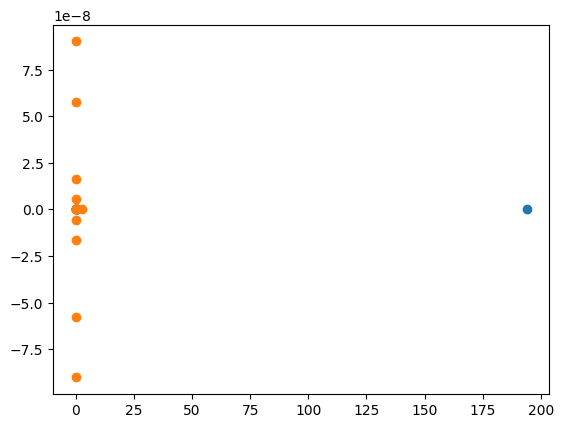

In [68]:
import matplotlib.pyplot as plt

plt.scatter(e0.real, e0.imag)
plt.scatter(e1.real, e1.imag)